# Segmenting Lung X-ray Images with the Segment Anything Model
### Advanced Deep Learning 2022
Notebook written by [Jakob Ambsdorf](mailto:jaam@di.ku.dk).
Lung x-ray code originally written by Mathias Perslev. It has been changed slightly by Christian Igel and subsequently slightly updated [Stefan Sommer](mailto:sommer@di.ku.dk).
SAM related code (c) Meta Platforms, Inc. and affiliates.

We consider the data described in:
Bram van Ginneken, Mikkel B. Stegmann, Marco Loog. [Segmentation of anatomical structures in chest radiographs using supervised methods: a comparative study on a public database](https://doi.org/10.1016/j.media.2005.02.002). *Medical Image Analysis* 10(1): 19-40, 2006

## Object masks from prompts with SAM

The Segment Anything Model (SAM) predicts object masks given prompts that indicate the desired object. The model first converts the image into an image embedding that allows high quality masks to be efficiently produced from a prompt. 

The `SamPredictor` class provides an easy interface to the model for prompting the model. It allows the user to first set an image using the `set_image` method, which calculates the necessary image embeddings. Then, prompts can be provided via the `predict` method to efficiently predict masks from those prompts. The model can take as input both point and box prompts, as well as masks from the previous iteration of prediction.

## Environment Set-up

If running locally using jupyter, first install `segment_anything` in your environment using the [installation instructions](https://github.com/facebookresearch/segment-anything#installation) in the repository. If running from Google Colab, set `using_colab=True` below and run the cell. In Colab, be sure to select 'GPU' under 'Edit'->'Notebook Settings'->'Hardware accelerator'.

In [1]:
using_colab = False

In [2]:
if using_colab:
    import torch
    import torchvision
    print("PyTorch version:", torch.__version__)
    print("Torchvision version:", torchvision.__version__)
    print("CUDA is available:", torch.cuda.is_available())
    import sys
    !{sys.executable} -m pip install opencv-python matplotlib
    !{sys.executable} -m pip install 'git+https://github.com/facebookresearch/segment-anything.git'
    
    !mkdir images
    !wget -P images https://raw.githubusercontent.com/facebookresearch/segment-anything/main/notebooks/images/truck.jpg
    !wget -P images https://raw.githubusercontent.com/facebookresearch/segment-anything/main/notebooks/images/groceries.jpg
        
    !wget https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth

## Set-up

Necessary imports and helper functions for displaying points, boxes, and masks.

In [3]:
import numpy as np
import torch
import matplotlib.pyplot as plt

import urllib.request
import os
from tqdm import tqdm

import torchmetrics
f1 = torchmetrics.F1Score(task="binary")

In [4]:
def show_mask(mask, ax, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([30/255, 144/255, 255/255, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)
    
def show_points(coords, labels, ax, marker_size=375):
    pos_points = coords[labels==1]
    neg_points = coords[labels==0]
    ax.scatter(pos_points[:, 0], pos_points[:, 1], color='green', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)
    ax.scatter(neg_points[:, 0], neg_points[:, 1], color='red', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)   
    
def show_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor='green', facecolor=(0,0,0,0), lw=2))    


# Chest X-ray Dataset

In [5]:
def plot_image_with_segmentation(image, segmentation, ax=None):
    """
    Plots an image with overlayed segmentation mask
    
    Returns: plt.fig and ax objects
    """
    if ax is None:
        fig = plt.figure(figsize=(8, 8))
        ax = fig.add_subplot(111)
        ax.axis("off")
    
    ax.imshow(image.squeeze(), cmap="gray")
    mask = np.ma.masked_where(segmentation == 0, segmentation)
    ax.imshow(mask.squeeze(), cmap="Set1", alpha=0.5)
    return plt.gcf(), ax

def plot_image_mask_box_points(image, masks=None, boxes=None, points=None, input_label=None, ax=None):
    """    
    Returns: plt.fig and ax objects
    """
    if ax is None:
        fig = plt.figure(figsize=(4, 4))
        ax = fig.add_subplot(111)
        ax.axis("off")
    
    ax.imshow(image.squeeze(), cmap="gray")
    if masks is not None:
        for mask in masks:
            show_mask(mask, plt.gca())
    if (points is not None) and (input_label is not None):
        show_points(points, input_label, plt.gca())
    if boxes is not None:
        for box in boxes:
            show_box(box=box, ax=plt.gca())
    plt.axis('off')
    plt.show()

    return plt.gcf(), ax


def load_npz_dataset(path, keys=('x_train', 'y_train', 'x_val', 'y_val', 'x_test', 'y_test')):
    archive = np.load(path)
    return [archive.get(key) for key in keys]

In [6]:
def map_interval(image, from_min, from_max, to_min, to_max):
    """
    Map values from [from_min, from_max] to [to_min, to_max]
    """
    from_range = from_max - from_min
    to_range = to_max - to_min
    # scaled = np.array((image - from_min) / float(from_range), dtype=float)
    scaled = (image - from_min) / float(from_range)
    return to_min + (scaled * to_range)

In [7]:
# Load train/val/test data
data_root='./datasets'
data_npz='lung_field_dataset.npz'
data_fn = os.path.join(data_root, "lung_field_dataset.npz")
x_train, y_train, x_val, y_val, x_test, y_test = load_npz_dataset(data_fn)

0 255 (112, 256, 256, 3) (112, 256, 256)
0 255
0 255


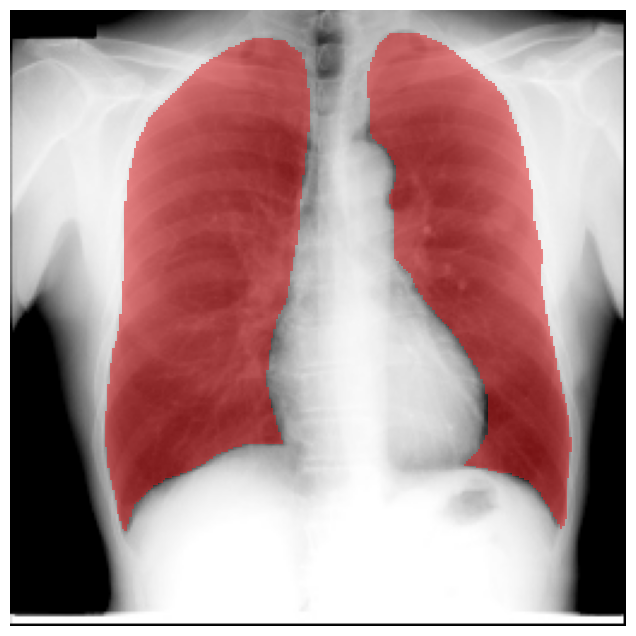

In [8]:
# TODO: 
# Bring images into the correct format for SAM:
# Image shape: (N, H, W, C=3)
# Mask shape: (N, H, W)
# Values: [0, 255] (uint8)

# YOUR CODE HERE
'''
On the other hand, ndarray.flatten always returns a flattened copy of the array. However, to guarantee a view in most cases, x.reshape(-1) may be preferable.
'''
def process_data(x, y, min=None, max=None):
    if min==None and max==None:
        min = x.min()
        max = x.max()
    
    x = (x - min)/(max - min) * 255
    x = x.astype(np.uint8)
    y = y.astype(np.uint8)
    x = np.concatenate([x,x,x], axis=3)
    y = y[:,:,:,0]
    return x, y, min, max

x_train, y_train, min, max = process_data(x_train, y_train)
print(np.min(x_train.reshape(-1)), np.max(x_train.reshape(-1)), x_train.shape, y_train.shape)

x_val, y_val,_,_= process_data(x_val, y_val, min, max) 
print(np.min(x_val.reshape(-1)), np.max(x_val.reshape(-1)))

x_test, y_test,_,_= process_data(x_test, y_test, min, max)
print(np.min(x_test.reshape(-1)), np.max(x_test.reshape(-1)))

# your data should pass the following asserts
assert x_train.shape == (112, 256, 256, 3)
assert y_train.shape == (112, 256, 256)
assert x_val.shape == (12, 256, 256, 3)
assert y_val.shape == (12, 256, 256)
assert x_test.shape == (123, 256, 256, 3)
assert y_test.shape == (123, 256, 256)

assert x_train.dtype == y_train.dtype == np.uint8
assert np.min(x_train) == 0
assert np.max(x_train) == 255

# Plot an example
fig, ax = plot_image_with_segmentation(x_train[0], y_train[0])
plt.show()

# Using Bounding Boxes from GT segmentations as Prompt

[[148   8 233 216]
 [ 39  11 124 217]]


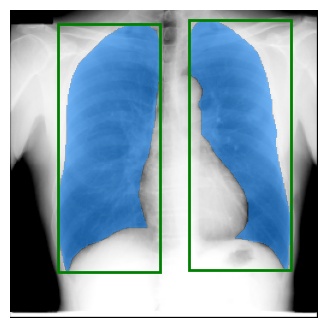

(<Figure size 640x480 with 0 Axes>, <Axes: >)

<Figure size 640x480 with 0 Axes>

In [9]:
# bounding boxes from segmentation masks
# bonding box format [x0, y0, x1, y1]

# TODO: Implement bounding box extraction from segmentation masks
from collections import deque

def bfs(mask, start, visited):
    queue = deque([start])
    segment = []
    directions = [(-1, 0), (1, 0), (0, -1), (0, 1)]  # Left, Right, Up, Down
    directions += [(-1, -1), (1, 1), (1, -1), (-1, 1)] # Up-left, Down-right, Up-right, Down-left
    h, w = mask.shape

    while queue:
        x, y = queue.popleft()
        if not mask[x, y]:
            continue
        mask[x, y] = False
        segment.append([x,y])

        for dx, dy in directions:
            ny, nx = y + dy, x + dx
            if 0 <= nx < h and 0 <= ny < w and mask[nx, ny]:
                queue.append((nx, ny))

    return segment

def get_bonding_box(mask):
    bonding_boxes = []
    mask = mask.squeeze().copy()
    for i in range(mask.shape[0]):
        for j in range(mask.shape[1]):
            if mask[i, j]:
                # print(f'mask[{i}, {j}]')
                segment = np.array(bfs(mask, [i, j], mask))
                if len(segment) > 100:
                    # print('len(segment):', len(segment), segment.shape)
                    min_y, min_x = np.min(segment, axis=0)
                    max_y, max_x = np.max(segment, axis=0)
                    bonding_boxes.append([min_x, min_y, max_x, max_y])

    return np.array(bonding_boxes)

example_img, example_mask = x_train[0], y_train[0]
boxes = get_bonding_box(example_mask)
print(boxes)
plot_image_mask_box_points(image=example_img, masks=[example_mask], boxes=boxes)

# Object Detection Model to predict Bounding Boxes

In [10]:
# TODO: Implement an object detection model to find the left and right lung bounding boxes

## Generate datasets


In [11]:
x_train.shape, y_train.shape, x_val.shape, y_val.shape, x_test.shape, y_test.shape

((112, 256, 256, 3),
 (112, 256, 256),
 (12, 256, 256, 3),
 (12, 256, 256),
 (123, 256, 256, 3),
 (123, 256, 256))

In [12]:
def generate_box_set(mask_dataset):
    box_set = []
    for mask in mask_dataset:
        boxes = get_bonding_box(mask)
        if boxes.shape != (2,4):
            plot_image_mask_box_points(image=example_img, 
                                        masks=[mask], 
                                        boxes=boxes)
            print('Error:', boxes.shape, boxes)
            break
        box_set.append(boxes)
    box_set = np.array(box_set)
    return box_set

box_set_train = generate_box_set(y_train)
print(box_set_train.shape)
box_set_test = generate_box_set(y_test)
print(box_set_test.shape)
box_set_val = generate_box_set(y_val)
print(box_set_val.shape)

(112, 2, 4)
(123, 2, 4)
(12, 2, 4)


In [23]:
import os
import torch
import matplotlib.pyplot as plt

from torchvision.io import read_image
from torchvision.ops.boxes import masks_to_boxes
from torchvision import tv_tensors
from torchvision.transforms.v2 import functional as F


class PennFudanDataset(torch.utils.data.Dataset):
    def __init__(self, transforms, images, bboxes, masks):
        self.transforms = transforms
        # load all image files, sorting them to
        # ensure that they are aligned
        self.imgs = images
        self.bboxes = bboxes
        self.masks = masks

    def __getitem__(self, idx):
        # load images and masks
        img = self.imgs[idx]
        # img = tv_tensors.Image(img.reshape(3, 256, 256))
        img = torch.from_numpy(img).float().permute(2, 0, 1)
        boxes = self.bboxes[idx]
        
        # num_objs = boxes.shape[0]
        num_objs = 2
        # of binary masks
        # masks = (mask == obj_ids[:, None, None]).to(dtype=torch.uint8)
        masks = [self.masks[idx], self.masks[idx]]

        # there is only one class
        labels = torch.ones((num_objs,), dtype=torch.int64)

        image_id = idx
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        # suppose all instances are not crowd
        iscrowd = torch.zeros((num_objs,), dtype=torch.int64)

        # Wrap sample and targets into torchvision tv_tensors:
        img = tv_tensors.Image(img)

        target = {}
        target["boxes"] = tv_tensors.BoundingBoxes(boxes, format="XYXY", canvas_size=F.get_size(img))
        target["masks"] = tv_tensors.Mask(masks)
        target["labels"] = labels
        target["image_id"] = image_id
        target["area"] = area
        target["iscrowd"] = iscrowd

        if self.transforms is not None:
            img, target = self.transforms(img, target)

        return img, target

    def __len__(self):
        return self.imgs.shape[0]

In [33]:
from engine import train_one_epoch, evaluate
from torchvision.transforms import v2 as T

def get_transform(train):
    transforms = []
    if train:
        transforms.append(T.RandomHorizontalFlip(0.5))
    transforms.append(T.ToDtype(torch.float, scale=True))
    transforms.append(T.ToPureTensor())
    return T.Compose(transforms)

# train on the GPU or on the CPU, if a GPU is not available
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

# our dataset has two classes only - background and person
num_classes = 2
# use our dataset and defined transformations
dataset = PennFudanDataset(get_transform(train=True), x_train, box_set_train, y_train)
dataset_val = PennFudanDataset(get_transform(train=False), x_val, box_set_val, y_val)

In [34]:
len(dataset)

112

In [35]:
# # split the dataset in train and test set
# indices = torch.randperm(len(dataset)).tolist()
# dataset = torch.utils.data.Subset(dataset, indices[:-50])
# dataset_test = torch.utils.data.Subset(dataset_val, indices[-50:])
import utils

# define training and validation data loaders
data_loader = torch.utils.data.DataLoader(
    dataset,
    batch_size=2,
    shuffle=True,
    collate_fn=utils.collate_fn
)

data_loader_test = torch.utils.data.DataLoader(
    dataset_val,
    batch_size=1,
    shuffle=False,
    collate_fn=utils.collate_fn
)

In [36]:
images, targets = next(iter(data_loader))
images = list(image for image in images)
targets = [{k: v for k, v in t.items()} for t in targets]
targets

[{'boxes': tensor([[147,  29, 227, 250],
          [ 27,  32, 112, 243]]),
  'masks': tensor([[[0, 0, 0,  ..., 0, 0, 0],
           [0, 0, 0,  ..., 0, 0, 0],
           [0, 0, 0,  ..., 0, 0, 0],
           ...,
           [0, 0, 0,  ..., 0, 0, 0],
           [0, 0, 0,  ..., 0, 0, 0],
           [0, 0, 0,  ..., 0, 0, 0]],
  
          [[0, 0, 0,  ..., 0, 0, 0],
           [0, 0, 0,  ..., 0, 0, 0],
           [0, 0, 0,  ..., 0, 0, 0],
           ...,
           [0, 0, 0,  ..., 0, 0, 0],
           [0, 0, 0,  ..., 0, 0, 0],
           [0, 0, 0,  ..., 0, 0, 0]]], dtype=torch.uint8),
  'labels': tensor([1, 1]),
  'image_id': 91,
  'area': array([17680, 17935]),
  'iscrowd': tensor([0, 0])},
 {'boxes': tensor([[ 25,  20, 119, 204],
          [146,  23, 228, 203]]),
  'masks': tensor([[[0, 0, 0,  ..., 0, 0, 0],
           [0, 0, 0,  ..., 0, 0, 0],
           [0, 0, 0,  ..., 0, 0, 0],
           ...,
           [0, 0, 0,  ..., 0, 0, 0],
           [0, 0, 0,  ..., 0, 0, 0],
           [0, 0, 0,

In [39]:
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor

def get_model_instance_segmentation(num_classes):
    # load an instance segmentation model pre-trained on COCO
    # model = torchvision.models.detection.maskrcnn_resnet50_fpn(weights="DEFAULT")
    model = torchvision.models.detection.fasterrcnn_resnet50_fpn_v2(pretrained=True)

    # get number of input features for the classifier
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    # replace the pre-trained head with a new one
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

    return model

In [40]:

# get the model using our helper function
model = get_model_instance_segmentation(num_classes)

# move model to the right device
model.to(device)

# construct an optimizer
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(
    params,
    lr=0.005,
    momentum=0.9,
    weight_decay=0.0005
)

# and a learning rate scheduler
lr_scheduler = torch.optim.lr_scheduler.StepLR(
    optimizer,
    step_size=3,
    gamma=0.1
)

# let's train it just for 2 epochs
num_epochs = 2

for epoch in range(num_epochs):
    # train for one epoch, printing every 10 iterations
    train_one_epoch(model, optimizer, data_loader, device, epoch, print_freq=10)
    # update the learning rate
    lr_scheduler.step()
    # evaluate on the test dataset
    evaluate(model, data_loader_test, device=device)

print("That's it!")

/home/seelur/enter/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/seelur/enter/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_V2_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


torch.Size([1024, 2]) torch.Size([1024])
tensor([0, 1, 1,  ..., 0, 1, 1])
Epoch: [0]  [ 0/56]  eta: 0:15:25  lr: 0.000096  loss: 1.1471 (1.1471)  loss_classifier: 0.9017 (0.9017)  loss_box_reg: 0.2297 (0.2297)  loss_objectness: 0.0068 (0.0068)  loss_rpn_box_reg: 0.0089 (0.0089)  time: 16.5343  data: 0.0337
torch.Size([1024, 2]) torch.Size([1024])
tensor([0, 0, 0,  ..., 0, 1, 1])
torch.Size([1024, 2]) torch.Size([1024])
tensor([1, 1, 0,  ..., 0, 1, 1])
torch.Size([1024, 2]) torch.Size([1024])
tensor([0, 0, 0,  ..., 0, 1, 1])
torch.Size([1024, 2]) torch.Size([1024])
tensor([1, 0, 0,  ..., 0, 1, 1])
torch.Size([1024, 2]) torch.Size([1024])
tensor([0, 1, 0,  ..., 0, 1, 1])
torch.Size([1024, 2]) torch.Size([1024])
tensor([0, 0, 0,  ..., 0, 1, 1])
torch.Size([1024, 2]) torch.Size([1024])
tensor([0, 1, 0,  ..., 0, 1, 1])
torch.Size([1024, 2]) torch.Size([1024])
tensor([0, 1, 1,  ..., 0, 1, 1])
torch.Size([1024, 2]) torch.Size([1024])
tensor([1, 0, 0,  ..., 0, 1, 1])
torch.Size([1024, 2]) torc

: 

In [ ]:
# For Training
images, targets = next(iter())
images = list(image for image in images)
targets = [{k: v for k, v in t.items()} for t in targets]
output = model(images, targets)  # Returns losses and detections
print(output)

In [ ]:
#import sys
#sys.path.append("..")
from segment_anything import sam_model_registry, SamPredictor

sam_checkpoint = "models/sam_vit_h_4b8939.pth"
model_type = "vit_h"

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
sam.to(device=device)

predictor = SamPredictor(sam)